In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import sys
import argparse
import os
import numpy as np
from numpy.random import uniform
import pandas as pd
from itertools import product
import datetime
import glob
import re
from numpy import ma
%matplotlib inline
# %matplotlib notebook
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams['figure.figsize'] = (10,5) 
# plt.rcParams['figure.figsize'] = (10,5.625)   # 16:9
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# plt.rcParams['figure.figsize'] = (10*2,6.180*2)    #golden ratio

In [4]:
# https://bougui505.github.io/2016/08/31/compute_the_shortest_path_on_a_grid_using_python.html
def dijkstra(V):
    mask = V.mask
    visit_mask = mask.copy() # mask visited cells
    m = np.ones_like(V) * np.inf
    connectivity = [(i,j) for i in [-1, 0, 1] for j in [-1, 0, 1] if (not (i == j == 0))]
    cc = np.unravel_index(V.argmin(), m.shape) # current_cell
    m[cc] = 0
    P = {}  # dictionary of predecessors 
    #while (~visit_mask).sum() > 0:
    for _ in range(V.size):
        #print cc
        neighbors = [tuple(e) for e in np.asarray(cc) - connectivity 
                     if e[0] > 0 and e[1] > 0 and e[0] < V.shape[0] and e[1] < V.shape[1]]
        neighbors = [ e for e in neighbors if not visit_mask[e] ]
        tentative_distance = np.asarray([V[e]-V[cc] for e in neighbors])
        for i,e in enumerate(neighbors):
            d = tentative_distance[i] + m[cc]
            if d < m[e]:
                m[e] = d
                P[e] = cc
        visit_mask[cc] = True
        m_mask = ma.masked_array(m, visit_mask)
        cc = np.unravel_index(m_mask.argmin(), m.shape)
    return m, P

In [5]:
def shortestPath(start, end, P):
    Path = []
    step = end
    while 1:
        Path.append(step)
        if step == start: break
        step = P[step]
    Path.reverse()
    return np.asarray(Path)

In [6]:
all_data = pd.read_feather("/Users/weilu/Research/data/pulling/19_Feb_data_1.feather")

In [7]:
test = all_data.query("temp=='400'").query("perturbation=='original'").query("mode=='2d_z_qw'")

In [8]:
x=1
y=2
z=3
zmin = 0
zmax=20
data = test[["index", "x","y","f"]].values
#         print(data)
data = data[~np.isnan(data).any(axis=1)] # remove rows with nan
data = data[~(data[:,z] > zmax)] # remove rows of data for z not in [zmin zmax]
data = data[~(data[:,z] < zmin)]
size = 20
xi = np.linspace(min(data[:,x]), max(data[:,x]), size)
yi = np.linspace(min(data[:,y]), max(data[:,y]), size)
zi = griddata((data[:,x], data[:,y]), data[:,z], (xi[None,:], yi[:,None]), method='linear')

In [13]:
P

{(1, 2): (2, 3),
 (1, 3): (2, 4),
 (1, 4): (2, 4),
 (1, 5): (2, 4),
 (1, 6): (2, 5),
 (1, 7): (2, 8),
 (1, 8): (2, 8),
 (2, 1): (2, 2),
 (2, 2): (2, 3),
 (2, 3): (3, 4),
 (2, 4): (3, 4),
 (2, 5): (3, 4),
 (2, 6): (3, 5),
 (2, 7): (3, 6),
 (2, 8): (3, 7),
 (2, 9): (2, 8),
 (2, 10): (3, 9),
 (2, 11): (3, 10),
 (2, 12): (3, 11),
 (2, 13): (2, 12),
 (3, 1): (2, 2),
 (3, 2): (2, 3),
 (3, 3): (4, 4),
 (3, 4): (4, 4),
 (3, 5): (4, 4),
 (3, 6): (3, 5),
 (3, 7): (3, 6),
 (3, 8): (3, 7),
 (3, 9): (2, 8),
 (3, 10): (3, 9),
 (3, 11): (4, 10),
 (3, 12): (4, 13),
 (3, 13): (4, 14),
 (3, 14): (4, 15),
 (3, 15): (4, 15),
 (3, 16): (4, 15),
 (3, 17): (4, 16),
 (4, 2): (3, 3),
 (4, 3): (4, 4),
 (4, 4): (5, 5),
 (4, 5): (5, 5),
 (4, 6): (5, 5),
 (4, 7): (3, 6),
 (4, 8): (3, 7),
 (4, 9): (3, 9),
 (4, 10): (3, 9),
 (4, 11): (5, 12),
 (4, 12): (5, 13),
 (4, 13): (5, 14),
 (4, 14): (5, 13),
 (4, 15): (5, 16),
 (4, 16): (5, 15),
 (4, 17): (5, 16),
 (4, 18): (5, 17),
 (4, 19): (5, 18),
 (5, 2): (4, 3),
 (5, 3)

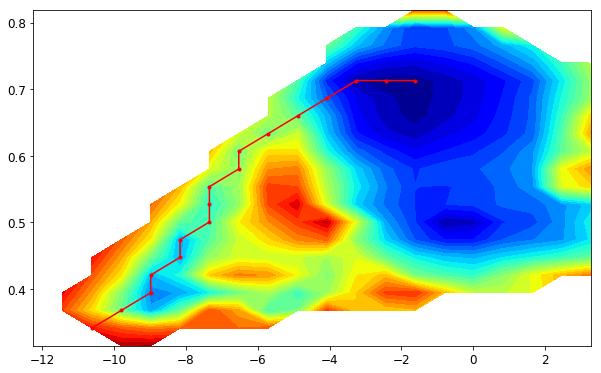

In [10]:
zi = np.where(np.isnan(zi), 50, zi)
V = ma.masked_array(zi, zi>40)
D, P = dijkstra(V)
source = np.unravel_index(V.argmin(), V.shape)
# source = (17,35)
path = shortestPath(source, (1,2), P)
plt.contourf(xi, yi, V, 30, cmap='jet')
# plt.plot(path[:,1], path[:,0], 'r.-')
plt.plot(xi[path[:,1]], yi[path[:,0]], 'r.-')

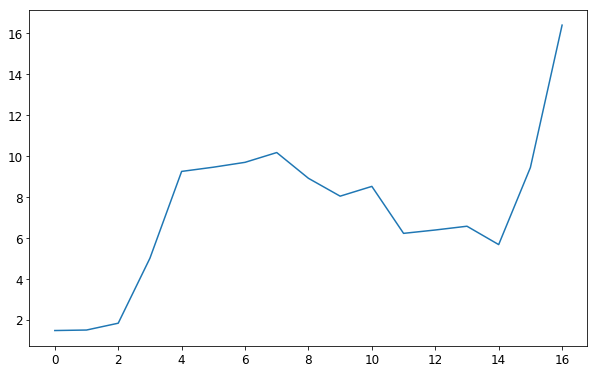

In [12]:
f_on_path = [zi[tuple(p)] for p in path]
plt.plot(f_on_path)